In [1]:
import numpy as np
from matplotlib import pyplot as plt

from warper import simulate_2d_only_memory_anharmonic_1 as simulate_2d_only_memory_anharmonic

from multiprocessing import Pool

import os, pickle
from tqdm.notebook import tqdm

import pandas as pd

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [58]:
from nsdesolve import Uxy_2

In [2]:
plt.rcParams["figure.facecolor"] = "white"

In [3]:
pool = Pool(4)

In [9]:
def get_cov(R,S,H):
    Z = np.zeros(len(R))
    return np.array([[R,Z,Z,H],
                     [Z,R,-H,Z],
                     [Z,-H,S,Z],
                     [H,Z,Z,S]])

def omega_kumulant(A,B,g0,ka):
    bigO=A + 2*B/ka**2/g0
    
    op2 = 1/2 * (bigO+abs(bigO)*np.sqrt(1+8*B/g0/bigO**2))
    om2 = 1/2 * (bigO-abs(bigO)*np.sqrt(1+8*B/g0/bigO**2))
    return op2, om2
 
def get_RSH(o0,g0,b,ka):
    mu = ka
    S = 1/g0/2/ka**2*(ka**2+o0**2+g0*ka+b**2)
    R = 1/g0/2/o0**2/ka**2 * (o0**2+ka**2)
    H = - 1/2/g0/ka**2*b
    
    return R,S,H, 2*(R*S+H**2)

def mean_with_err(arr, axis):
    return arr.mean(axis=axis), arr.std(axis=axis)/np.sqrt(arr.shape[axis])

In [10]:
g0 = 0.3
ka = 1
b = 1
A= -2
B= 0.05

In [11]:
op2, om2 = omega_kumulant(A,B,g0,ka)

In [71]:
R,S,H,_ = get_RSH(np.sqrt(op2),g0,b,ka)

In [14]:
N=2000000
warmup=0
dt=0.001
samples=1000
skip=100
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

In [15]:
(len([1]) * N * runs * samples *4 // skip) * 4 / 1024**3

1.1920928955078125

In [19]:
sigma = get_cov(np.array([R]), np.array([S]), np.array([H]))

In [24]:
sigma[...,0]

array([[10.90230211,  0.        ,  0.        , -1.66666667],
       [ 0.        , 10.90230211,  1.66666667,  0.        ],
       [ 0.        ,  1.66666667,  4.1341007 ,  0.        ],
       [-1.66666667,  0.        ,  0.        ,  4.1341007 ]])

In [29]:
x0,y0,vx0,vy0 = np.random.multivariate_normal([0,0,0,0], sigma[...,0], samples).T
kwargs = dict(x0=x0,y0=y0,vx0=vx0,vy0=vy0,
    N=N, samples=samples,
    dt=dt, warmup=warmup, skip=skip,
    A=-A,B=B,
    gamma0=g0,b=b, kappa=ka)
result = simulate_2d_only_memory_anharmonic(pool,runs,**kwargs)

In [33]:
result = np.array(result); result.shape

(6, 4000, 20000)

### Start Analisys

In [81]:
cov_all = np.einsum("akj,bkj->jab", result[:4,:,:],result[:4,:,:],optimize=True)/(result.shape[1]-1)
# cov = cov[df[df.b].index]

In [88]:
cov=cov_all[:1000]

In [89]:
cov.shape

(1000, 4, 4)

In [90]:
sp = 1
cov_R = cov[::sp,(0,1),(0,1)].transpose(0,1).reshape(-1,2)
cov_S = cov[::sp,(2,3),(2,3)].transpose(0,1).reshape(-1, 2)
cov_H = cov[::sp,(0,1,2,3),(3,2,1,0)].transpose(0,1).reshape(-1, 4)
cov_Z = cov[::sp,(0,0,1,1,2,2,3,3),(1,2,0,3,0,3,1,2)].transpose(0,1).reshape(-1, 8)

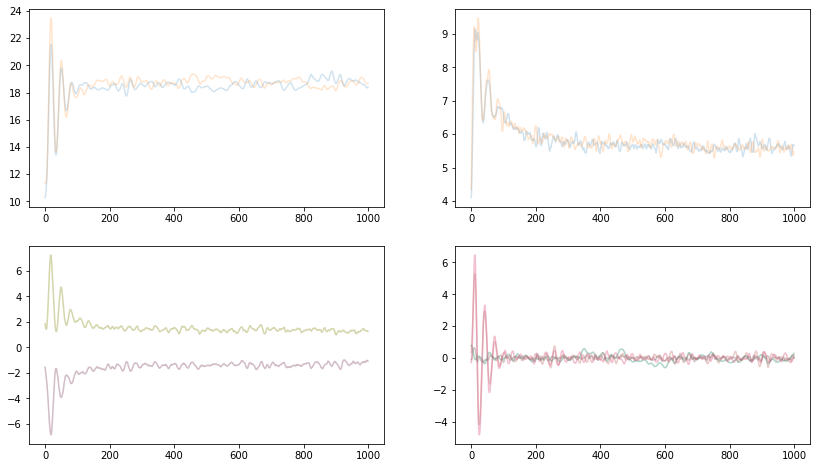

In [91]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
plt.plot(cov_R, alpha=0.2);
plt.subplot(2,2,2)
plt.plot(cov_S, alpha=0.2);
plt.subplot(2,2,3)
plt.plot(cov_H, alpha=0.2);
plt.subplot(2,2,4)
plt.plot(cov_Z, alpha=0.2);

In [48]:
stationari_treshold = 2000

In [49]:
result.shape

(6, 4000, 20000)

In [53]:
Rx,Ry, Sx, Sy,_,_ = result[...,stationari_treshold::10].var(axis=1)
Lx = result[0] * result[3]
Ly = result[1] * result[2]

Hx = Lx.mean(axis=0)
Hy = Ly.mean(axis=0)

In [65]:
Lx.shape

(4000, 20000)

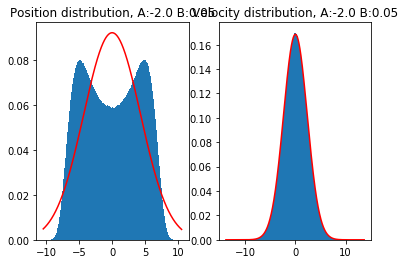

In [56]:
plt.subplot(1,2,1)
values=result[0:2,:,stationari_treshold:].flatten()
m, s = np.mean(values), np.std(values)
plt.title(f"Position distribution, A:{A:0.1f} B:{B:0.2f}")
_,x,_ = plt.hist(values, bins=1000, density=1);
plt.plot(x, 1/np.sqrt(2*np.pi)/s*np.exp(-(x-m)**2/2/s/s), c="r")

plt.subplot(1,2,2)
values=result[2:4,:,stationari_treshold:].flatten()
m, s = np.mean(values), np.std(values)
plt.title(f"Velocity distribution, A:{A:0.1f} B:{B:0.2f}")
_,x,_ = plt.hist(values, bins=1000, density=1);
plt.plot(x, 1/np.sqrt(2*np.pi)/s*np.exp(-(x-m)**2/2/s/s), c="r")

In [57]:
Hx

array([-1.30943869, -0.95604166, -1.2840585 , ..., -1.29615313,
       -1.25306879, -1.8197553 ])

In [62]:
res = result[...,stationari_treshold::]

ux, uy = Uxy_2(A, B, 0,0, 0, res[0].flatten(),res[1].flatten() )
uxs=(ux.reshape(res.shape[1], res.shape[2]))
uys=(uy.reshape(res.shape[1], res.shape[2]))


xry= res[0] * res[5]
yrx= res[1] * res[4]

uxry= uxs*res[5]
uyrx= uys*res[4]

In [63]:
Hx.shape

(4000,)

In [76]:
mean_with_err(Lx.flatten(), 0)

(-1.3654693831175024, 0.0010300521279795784)

In [67]:
H

-1.6666666666666667

In [74]:
meanQ, errQ=mean_with_err(uxry.flatten()/g0/ka**2, 0)

In [77]:
H+meanQ, errQ

(-1.3366547992338096, 0.002784036593447682)

In [79]:
errQ*100/meanQ

0.8436171144706217